# Vehicle Detection Project

#### _Various Methods were utlized from Self Driving Car Material Provided by Udacity_

** The goals / steps of this project are the following:**

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
3.
4. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
5. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
6. Estimate a bounding box for vehicles detected.


**Note: for the first two steps,  features are normalized and the selection for training and testing are randomized.**



# Necessary Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split



from P5_Functions import *

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

---
# A. Histogram of Oriented Gradients (HOG)

## 1. Feature Extractoin

### Objective: 
        Exract HOG features from the training images

### Overview

Compute a Histogram of Oriented Gradients [(HOG)](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) by

- optional **global image normalisation**: reduces the influence of illumination and shadowing using gamma power low
    - set by the **flag transform_sqrt**.
    - may cause an error if your image contains negative values
- **computing the gradient image in x and y**: capture contours and some texture info.
    - set using **pixels_per_cell** parameter
- **computing gradient histograms**: captures local image content via 1D local histogram that forms the basis of orientation histogram that considers gadient magnitude of the pixels in the cell.
    - Typical values for orientation are between 6 and 12 bins.
- **normalising across blocks**: creating the desired descriptor. Leads to a more robust feature set.
    - set using **cells_per_block ** parameter
- **flattening into a feature vector**: collect all descriptors into a combined feature vector.




### Method
I started by reading in all the vehicle and non-vehicle images. Here is an example of one of each of the vehicle and non-vehicle classes, I also show the resulting HOG images for both of them

In [3]:
#---------------Read Car Data ---------------

car_imgs = glob.glob('train_images/car_imgs/*.png')
noncar_imgs = glob.glob('train_images/noncar_imgs/*.png')

cars_list = []
notcars_list = []


for c_img, nc_img in zip(car_imgs,noncar_imgs):
    cars_list.append(c_img)
    notcars_list.append(nc_img)

print("length of car list: ", len(cars_list), "\nlength of non-car list: ", len(notcars_list))    

# For testing purposes reduce the sample size because
sample_size = 500 #len(cars_list))
cars = cars_list[0:sample_size]
notcars = notcars_list[0:sample_size]


length of car list:  6941 
length of non-car list:  6941


In [4]:
#------------Select Random Images to Show--------------

indx = np.random.randint(0, len(cars))

car_image = mpimg.imread(cars[indx])
notcar_image = mpimg.imread(notcars[indx])

car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)                    
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

cfeatures, car_hog_image = get_hog_features(car_gray, orient=8, 
                        pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)

ncfeatures, notcar_hog = get_hog_features(notcar_gray, orient=8, 
                        pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)



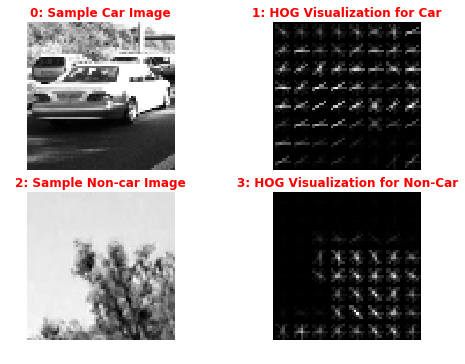

In [5]:
#---------Show Sample Images--------------------
img_list = np.array([car_gray,car_hog_image,notcar_gray, notcar_hog ])
title_list = np.array(['Sample Car Image','HOG Visualization for Car' ,'Sample Non-car Image', 'HOG Visualization for Non-Car'])

show_images(img_list, title_list, (7,5), (2,2) )
plt.savefig('0_car_noncar_HOG.png')


Next I show how various color sapces may capture and show different information form different angles.

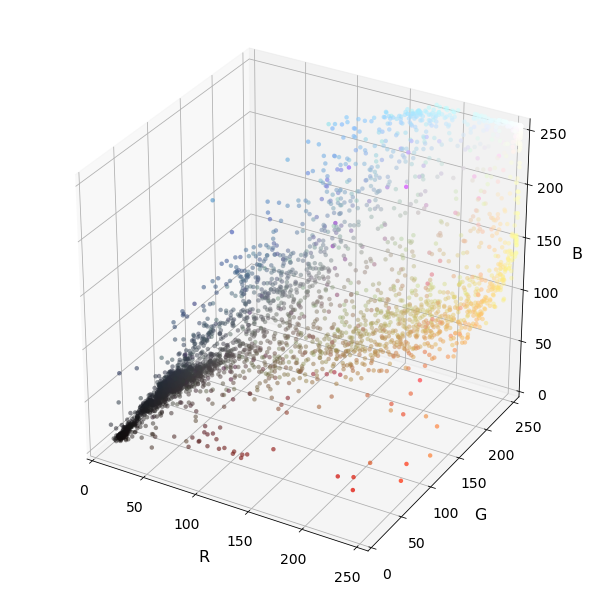

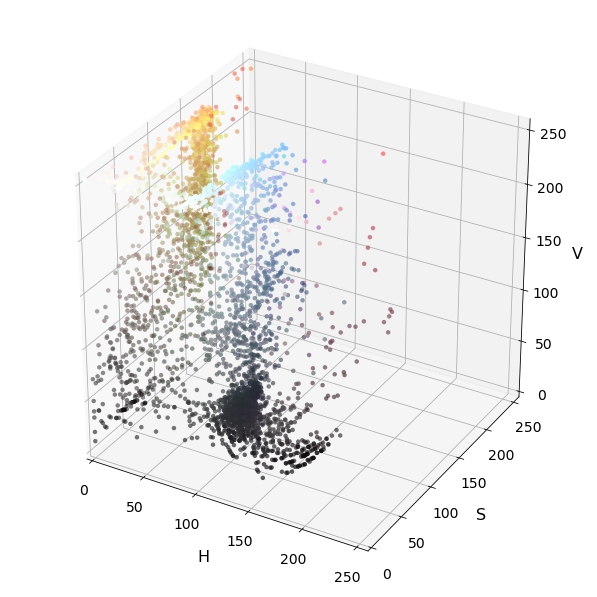

In [6]:
# Read a color image using openCV
img = cv2.imread(cars[indx])

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.savefig('1_RGB_RandomImg.png')
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.savefig('2_HSV_RandomImg.png')
plt.show()



### Useful conclusion:

            HSV seems to cluster information better than RGB

** Motivated by the previous results, I then extract some features and show the effect of normalization as well as various parameters in HOG. Without loss of generality, 500 car and noncar images were considered**

In [7]:
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


color_space = ['HLS', 'RGB', 'HSV', 'YCrCb']
orient = [6, 12]  # HOG orientations
hog_channel = [0,2]


In [8]:
titles = []
normal_list = []
scaled_list = []

for color in color_space:
    for direc in orient:
        for ch in hog_channel:
            
            car_features  = extract_features(cars, color_space= color, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient= direc, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=ch, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


            notcar_features  = extract_features(notcars, color_space=color, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=direc, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=ch, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
            
            # Create an array stack of feature vectors

            X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
            # Fit a per-column scaler
            X_scaler = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler.transform(X)
            
            
            label = color + ", Orient of: " +str(direc) + ", Ch: " + str(ch)
            
            normal_list.append(X)
                        
            scaled_list.append(scaled_X)
            titles.append(label)
            
            """ 
            #for testing purposes to examine different effects
            #http://stackoverflow.com/questions/19189488/use-a-loop-to-plot-n-charts-python
            ---------------------
            plt.figure()
            plt.plot(X[100])
            plt.title(label)
            plt.show()
            """
            

### Visualizing the effect of parameter combinations on the random image

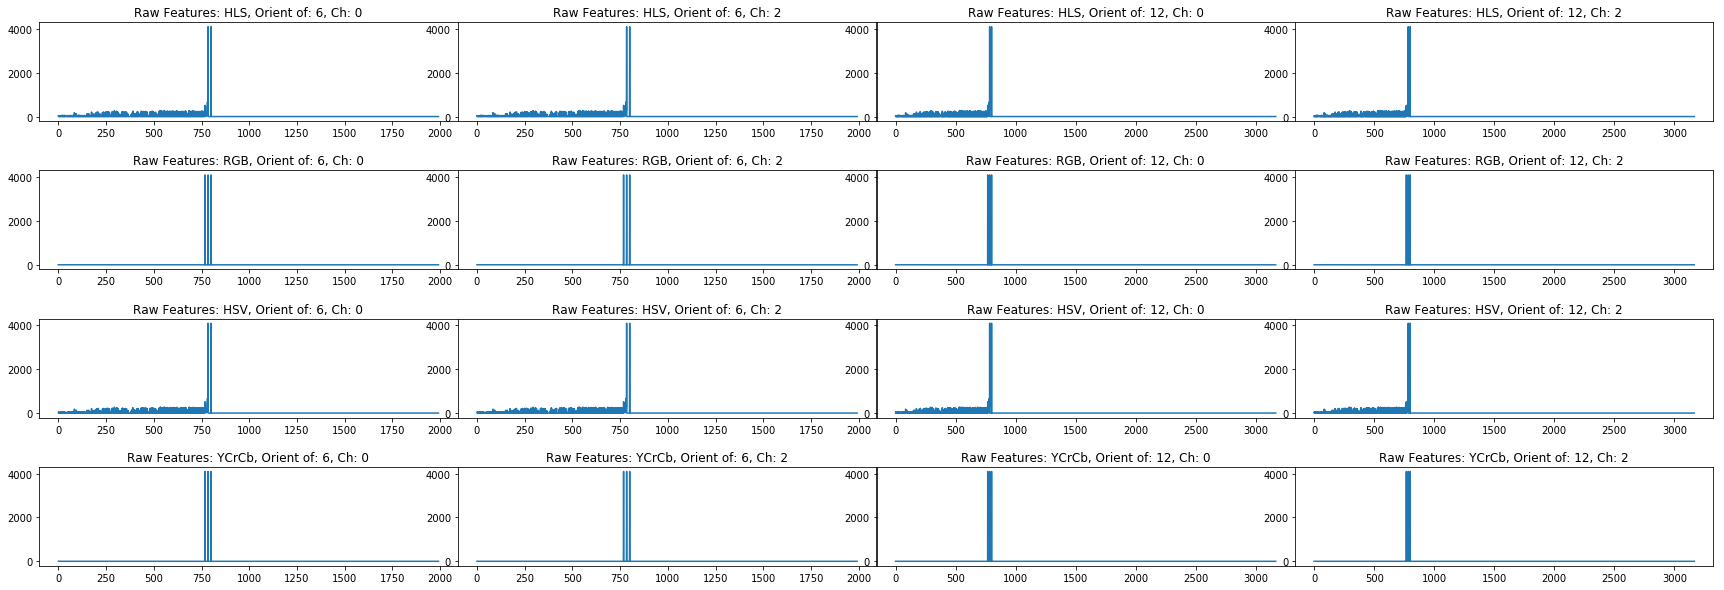

In [9]:
fig, axs = plt.subplots(4,4, figsize=(30, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(len(titles)):

    axs[i].plot(normal_list[i][indx]) 
    axs[i].set_title('Raw Features: '+titles[i])

plt.savefig('3_RowFeatureComparison.png')

### The following could be concluded from the above plots after closely zooming over some of them
1. For the same color schemes, as the degree of orientation increases from (6 to 12) the following happens:
    - The peak value shifts left as more zeros are introduced
    - Multiple peaks merge together. 
    - Small variations in featurs are mitigated
2. For various color schemes, HLS & HSV, capture more features. This is shown in the various fluctuations before reaching the peak. 

More information could be obtained by studying the scaled distribution

### And for the scaled version

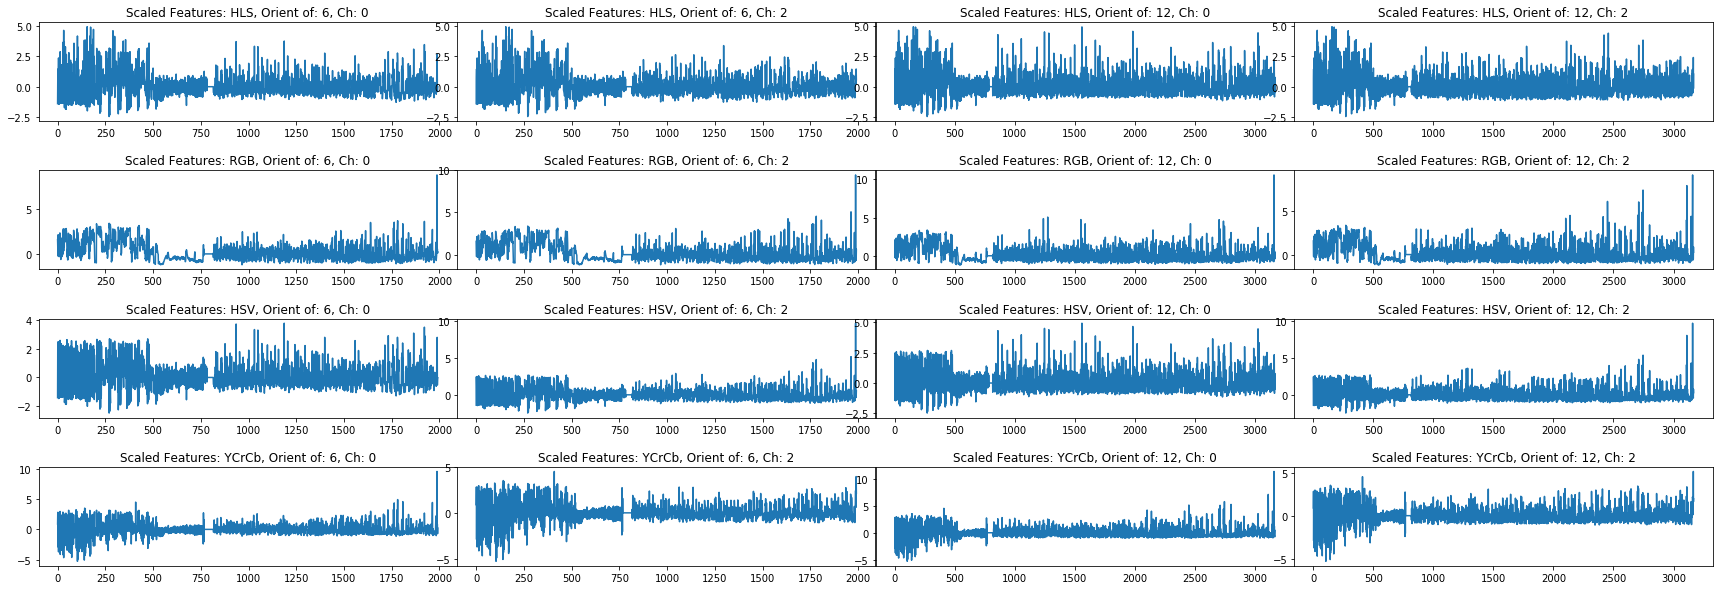

In [10]:
fig, axs = plt.subplots(4,4, figsize=(30, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(len(titles)):

    axs[i].plot(scaled_list[i][indx]) 
    axs[i].set_title('Scaled Features: '+titles[i])

plt.savefig('4_ScaledFeatureComparison.png')

### The following could be concluded 
1. The scaled version of both HLS & HSV produced somehow a balanced plot. This is expected as more weight is given to the previously observed low magnitude features.

### Conclusion:
==================

** Based on the above and in order to consider as many features as possible, I will start experimenting with the following, and adjust things accordingly:**
- Color Scheme   : HLS
- Oreintatio     : 12
- Channel        : 2
- pix_per_cell   : 8 
- cell_per_block : 2 
- spatial_size   : (32 32) 
- hist_bins      : 16    

---
## 2. Training the Classifier

- This was mainly accomplished by setting up the parameters and extracting features by combining the output of:
    - bin_spatial( )
    - color_hist( )
    - HOG_features( )
- The output was normalized

In [11]:
color_space = 'HLS'        # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12                # HOG orientations
pix_per_cell = 8           # HOG pixels per cell
cell_per_block = 2         # HOG cells per block
hog_channel = "ALL"        # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)    # Spatial binning dimensions

hist_bins = 16             # Number of histogram bins
spatial_feat = True        # Spatial features on or off
hist_feat = True           # Histogram features on or off
hog_feat = True            # HOG features on or off

In [12]:
#considering the whole training set
#-----------------------------------
sample_size = len(cars_list)

cars = cars_list[0:sample_size]
notcars = notcars_list[0:sample_size]

t=time.time()


car_features  = extract_features(cars, color_space= color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient= orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


notcar_features  = extract_features(notcars, color_space=color_space, 
            spatial_size=spatial_size, hist_bins=hist_bins, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat)



t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

92.49 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block


### Randomizing and Splitting Data

In [13]:
# Split up data into randomized training and test sets
#------------------------------------------------------
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 10176


### Choosing & Optimizing Classifier Parameters

- For classifier parameter selection I used: [**randomizedsearchcv()**](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html) function in **sklearn**
- svm_rbf is very slow as expected
- Below, I will experiment various classifiers 


#### Without loss of generality, the following is an example of how I decided on various other parameters. [sklearn documentation](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)

In [14]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


from scipy.stats import randint as sp_randint

# build a classifier
clf = RandomForestClassifier(n_estimators=20)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": [2],
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

t=time.time()
random_search.fit(X_train, y_train)
t2 = time.time()

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.982 (std: 0.001)
Parameters: {'min_samples_split': 2, 'max_features': 10, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3}

Model with rank: 2
Mean validation score: 0.979 (std: 0.001)
Parameters: {'min_samples_split': 2, 'max_features': 6, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6}

Model with rank: 3
Mean validation score: 0.977 (std: 0.000)
Parameters: {'min_samples_split': 2, 'max_features': 7, 'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3}



### Benchmarking Different Classifiers

In [15]:
def my_classifier(name, clf , X_train,y_train,X_test, y_test):
    
    t=time.time()
    clf.fit(X_train, y_train )
    t2 = time.time()

    print("=============== {:} Classifier ===============================\n".format(name))
    
    print(round(t2-t, 2), 'Seconds to train {:}...'.format(name))
    # Check the score of the SVC
    print('Test Accuracy of {:} = '.format(name), round(clf.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My {:} predicts: '.format(name), clf.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with {:}'.format(name))
    print("-----------------------------------------------------------------")
    
    return clf


In [16]:
svc = LinearSVC()
svc = my_classifier('Linear SVM ', svc , X_train,y_train,X_test, y_test)

#svm_rbf = svm.SVC(kernel='rbf', gamma=2, C=1)
#my_classifier('RBF SVM', svm_rbf , X_train,y_train,X_test, y_test)

random_forest = RandomForestClassifier(max_depth=10, n_estimators=10, max_features=10,criterion="entropy")
random_forest = my_classifier('Random Forest ', random_forest , X_train,y_train,X_test, y_test)

d_tree = DecisionTreeClassifier(max_depth=10)
d_tree = my_classifier('Decision Tree ', d_tree , X_train,y_train,X_test, y_test)

KNN = KNeighborsClassifier(2)
KNN = my_classifier('K-Nearest Neigboure ', KNN , X_train,y_train,X_test, y_test)

NB = GaussianNB()
NB = my_classifier('Naive Bayes ', NB , X_train,y_train,X_test, y_test)

MLP = MLPClassifier(alpha=1)
MLP = my_classifier('MLP ', MLP , X_train,y_train,X_test, y_test)



=============== Linear SVM  Classifier ===============================

3.85 Seconds to train Linear SVM ...
Test Accuracy of Linear SVM  =  0.996
My Linear SVM  predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
0.001 Seconds to predict 10 labels with Linear SVM 
-----------------------------------------------------------------
=============== Random Forest  Classifier ===============================

1.46 Seconds to train Random Forest ...
Test Accuracy of Random Forest  =  0.9777
My Random Forest  predicts:  [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
0.003 Seconds to predict 10 labels with Random Forest 
-----------------------------------------------------------------
=============== Decision Tree  Classifier ===============================

127.43 Seconds to train Decision Tree ...
Test Accuracy of Decision Tree  =  0.964
My Decision Tree  predicts:  [ 0

### Discussion

- Feeding Random Forest Classifier with right parameters not only completed the job in very short time, but also produced a very high accurecy score.
- MLP achieved the best accurecy score but it was very slow compared to others
- Naive Bayes was the fastest, but also the one with highest error.

**_The follwing table summarizes the findings and the itemes are ordered from better to worse according to the specified category_**


|order  |      Speed     |    Accurecy     | 
|:-----:|:--------------:|:---------------:|
| 1     |  Random Forest |   MLP           |
|  2    |  Naive Bayez   |   Linear SVM    |
|  3    |  Linear SVM    |   Random Forest |
|  4    |  KNN           |   Naive Bayez   |
|  5    |  MLP           |   Decision Tree |
|  6    |  Decision Tree |   KNN           |




## Training The Classifier

From the above benchmarking and analysis, the following could be concluded:

- Both Decision Tree and KNN could be altered to produce more accurecy. However, this would be reflected in a dramatic increase in latency especially when considering higher values for k in KNN. The reason for that is well understood given the large feature space we have and the exponential complexity of such algorithms.
- Linear SVM is very close in accurecy to MLP, and since it performs the job fast, I will utilize as a classifier it as a starting point.

---
# B. Implementing Sliding Window

just for the record, the random rectangles mentioned in the right up template are just awesome. :)


## 1. Identifying windows of interest
The easiest way to let equal small boxes to span the whole space. Like this:

            windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
            window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
            plt.imshow(window_img)



However, the previous process is very slow and performs unnecessary checks especially on empty boxes


### Optimizations

1. Restrict the search for only  height/4 of the image, the other one is sky and terrain
2. Establish and adaptive strategy to reduce the window size as you move further with the perspective

without loss of generality, and assuming overlap to be the same, the window is given by

        sliding_window = [(delta_img_size)- window*overlap]/ (window*overlap)
               = [delta_img_size/(window*overlap)] - 1

Since I only need to deal with a portion of the 'y-axis', the following can be written

        sliding_window = [y[1]-(y[1]-segma)]/(window_y*overlap_y)  -1 
               = segma/(window*overlap) -1

for simplicity, set the overlap to 0.5

        sliding_window + 1 = 2*segma/window.

Since the previous is an int division, then to obtain a minimum of 1 sliding window, 
should be at least = window_y ==>

        sliding_window + 1 = 2*window_y/window_y =1

**Useful conclusion**, 
    
        choose the portion of the image in y direction (**segma**) to be at least the same as y-window size

** Main Challenges**

        relating the output of int division to the various parameters. This issue can be handled but present extra unnecessary complexity for both the coder and the reviewer. :)

## NOTE:
- The following section was completed to meet the specifications in the rubric. Everything was augmented in one function when applying sliding window to the provided vedio.
- The details of the adaptive implementation, dimensions and overlap ratios are presented next

In [17]:
image = mpimg.imread('test_images/test1.jpg')

draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#M_image = image.astype(np.float32)/255

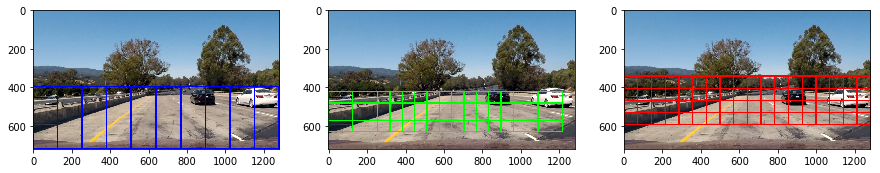

In [18]:

img_y, img_x = image.shape[0:2]

useful_space = int(0.75 * img_y )

#assuming the car is not directly imerging from the edges
#xStart_offset = 50
#xEnd_offset = 50
#-------------------------------------------------
margin1 = 0
segma1 = int(0.6*useful_space)

y_win1,x_win1  = segma1, int(img_x/2)

xStart1, xEnd1 = 0, img_x  
yStart1, yEnd1 = img_y-segma1, img_y-margin1

windows_1 = slide_window(image, x_start_stop=[xStart1, xEnd1], 
                        y_start_stop=[yStart1, yEnd1], 
                        xy_window=(x_win1, y_win1), 
                        xy_overlap=(0.8, 0.8))
                    
window_img1 = draw_boxes(image, windows_1, color=(0, 0, 255), thick=6)

#-------------------------------------------------
margin2 = int(0.1*img_y) #how much this overlaps with the previous window
segma2 = int(0.55*useful_space)
y_win2, x_win2  = int(segma2/2 ),int(img_x/4) 

xStart2, xEnd2 = 0, img_x  
yStart2, yEnd2 = img_y-segma2, img_y-margin2


windows_2 = slide_window(image, x_start_stop=[xStart2, xEnd2], 
                        y_start_stop=[yStart2, yEnd2], 
                        xy_window=(x_win2, y_win2), 
                        xy_overlap=(0.6, 0.6))
                    
window_img2 = draw_boxes(image, windows_2, color=(0, 255,0 ), thick=6)

#-------------------------------------------------

margin3 = int(0.15*img_y) #how much this overlaps with the previous window
segma3 = int(0.7*useful_space)

y_win3, x_win3 = int(segma3/3 ), int(img_x/9)

xStart3, xEnd3 = 0, img_x  
yStart3, yEnd3 = img_y-segma3, img_y-margin3


windows_3 = slide_window(image, x_start_stop=[xStart3, xEnd3], 
                         y_start_stop=[yStart3, yEnd3], 
                         xy_window=(x_win3, y_win3), 
                         xy_overlap=(0.5, 0.5))


window_img3 = draw_boxes(image, windows_3, color=(255, 0, 0), thick=6)


#-------------------------------------------------

fig,(ax1, ax2, ax3)  = plt.subplots(1,3, figsize = (15,10))

# Display the image
ax1.imshow(window_img1)
ax2.imshow(window_img2)
ax3.imshow(window_img3)

plt.savefig('5_AdaptiveSearchWindows.png')
plt.show()



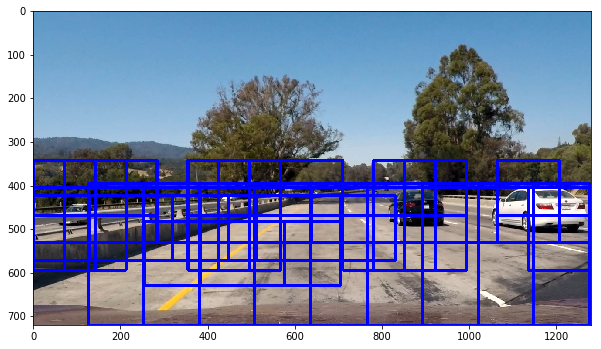

In [19]:
#Defining The window of interest
windows = windows_1+windows_2+windows_3

#Classifier could be { svc, random_forest, d_tree, KNN, NB, MLP }

classifier = svc

hot_windows = search_windows(image, windows, classifier, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

fig = plt.figure(figsize=(10,10))

plt.imshow(window_img)

plt.savefig('6_SlidingWindow.png')

## 2. Finding Cars on Test Images

Thanks to the very useful discussion and various inputs on [udacity forum.](
https://discussions.udacity.com/t/hog-sub-sampling-window-search/235413/39)

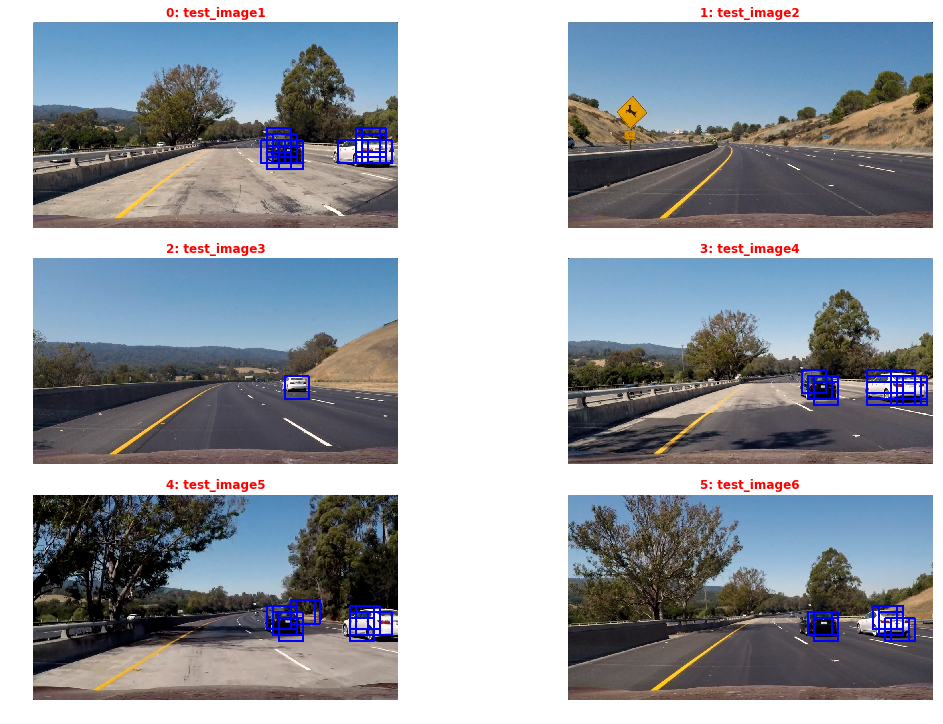

In [20]:

#Reading Images of interest
image_list = glob.glob('test_images/*.jpg')

ystart = 370
ystop = 550
scale = 1.3#1.15

Org_images = []
Found_Cars = []
Boxes_List = []

for fileName in image_list:
    # Read in each one by one
    image = mpimg.imread(fileName)
    out_img, My_Box_list = find_cars(image, ystart, ystop, scale, classifier, X_scaler, 
                                     orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    Org_images.append(image)
    Found_Cars.append(out_img)
    Boxes_List.append(My_Box_list)

#Show Results
titles = ['test_image1', 'test_image2', 'test_image3', 'test_image4', 'test_image5', 'test_image6']
show_images(np.array(Found_Cars), np.array(titles), (15,10), (3,2))

plt.savefig('7_Output of Sliding Window on cars.png')

## 2. Duplicate Detection and False Positive Removal

** Ultimately I searched on two scales using HLS 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result. Here are is the code that is followed by some example images:**

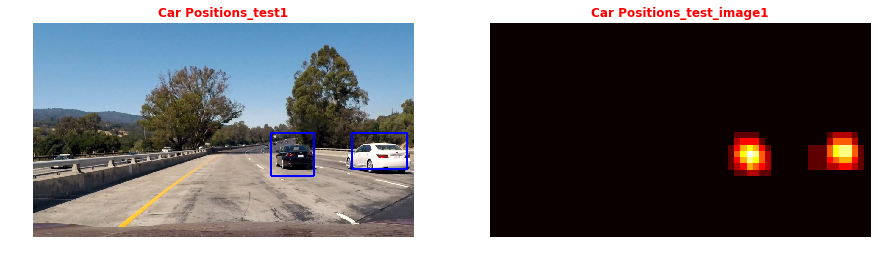

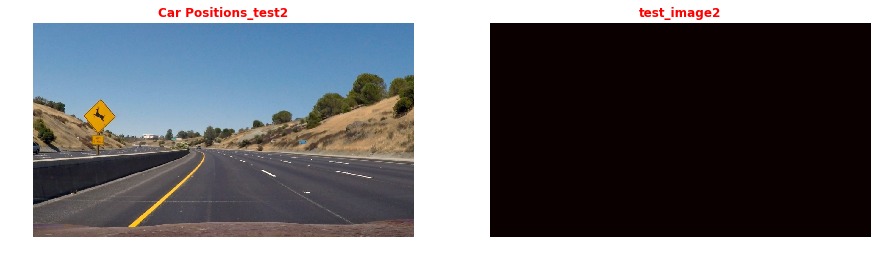

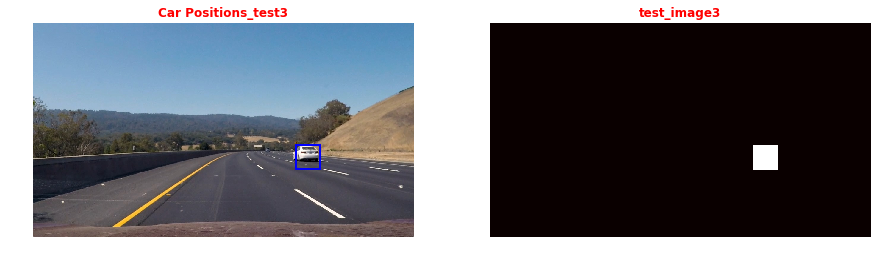

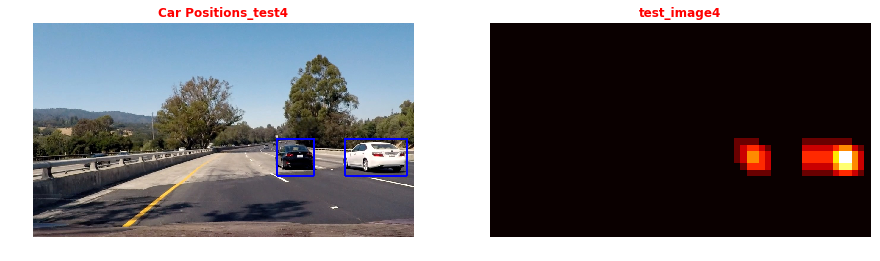

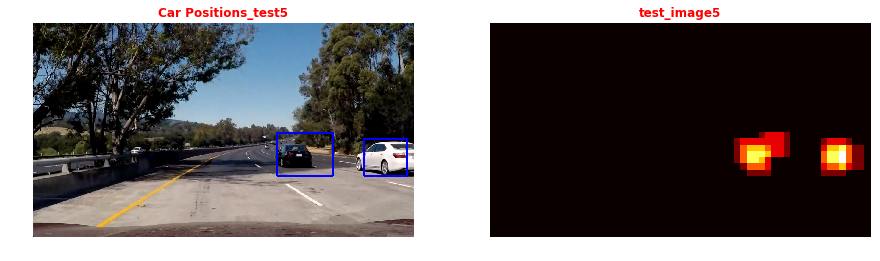

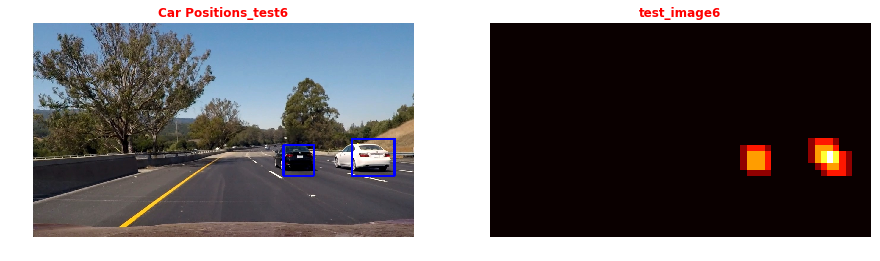

In [21]:
from scipy.ndimage.measurements import label

Heat_images = []
EnhancedBox_images = []

for box_list,my_image in zip(Boxes_List,Org_images):

    heat = np.zeros_like(my_image[:,:,0]).astype(np.float)
    
    if(len(box_list) == 0):
        
        EnhancedBox_images.append(my_image)
        Heat_images.append(heat)

        #continue
    
    else:
        
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,0.6)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        
        labels = label(heatmap)
        
        draw_img = draw_labeled_bboxes(np.copy(my_image), labels)

        EnhancedBox_images.append(draw_img)
        Heat_images.append(heatmap )


        
        
Position_titles = ['Car Positions_test1','Car Positions_test2', 'Car Positions_test3', 'Car Positions_test4', 'Car Positions_test5','Car Positions_test6']

heat_titles = ['Car Positions_test_image1','test_image2', 'test_image3', 'test_image4', 'test_image5','test_image6']


for img, img_gray, p_title, h_title in zip(EnhancedBox_images, Heat_images, Position_titles, heat_titles) :
   
    fig ,(ax1,ax2) = plt.subplots(1,2 , figsize=(15, 10))
   
    ax1.imshow(img)
    ax1.set_title(p_title, color ='r', fontweight='bold')
    ax1.axis('off')
    ax1.autoscale(False)
       
    ax2.imshow(img_gray.squeeze(),cmap='hot')
    ax2.set_title(h_title, color ='r', fontweight='bold')
    ax2.axis('off')
    ax2.autoscale(False)

    plt.show()
    
    plt.savefig('8_Combined boxes and Heat maps.png')


### 3. Finding Car Function Summary
Summarizing the previous findings in one function to be called when proessing the vedio


In [60]:
from scipy.ndimage.measurements import label

def get_Car_Boundries(box_list, my_image):
    
    heat = np.zeros_like(my_image[:,:,0]).astype(np.float)
    
    if(len(box_list) ==0):
        
        return my_image, heat

    else:
        
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,2)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(my_image), labels)

        return draw_img, heatmap

---
# Video Implementation



### combining overlapping bounding boxes

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

The previous section included some example result showing the heatmap from a series of frames of video, the result of scipy.ndimage.measurements.label() and the bounding boxes then overlaid on the last frame of video.

Next I try the previous technique on the provided vedio.

#### To handle the issue of Wobbly boxes
I utlized various hints from the forum and considered the following:

- At the beginning I  stored 7 frames and took and considered simple weighting with a previous frame
- After that, I started averaging every last 7 frames
- Any suggestions to improve this work is highly appreciated.



### Conclusion
The result of this section is shown in two files in the same folder that contains the source file. Both codes are shown below.
 
- **P5_No_Averaging.mp4: ** just calling the functions that classify a given frame and return a bounding box around detected cars


- **P5_Averaging.mp4: ** same as above with additional average heating presented. This was suggested in the forum to reduce false positive

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### 1. Detecting Cars without Averging

In [ ]:
def process_image(image):

    out_img, box_list = find_cars(image, ystart, ystop, scale, classifier, 
                                     X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    draw_img, heatmap = get_Car_Boundries(box_list, image)
        
    return draw_img

In [ ]:
P4_Simple = 'P5_No_Averging.mp4'
clip = VideoFileClip("project_video.mp4 ") # project_video.mp4    test_video.mp4  


processed_Simple = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_Simple.write_videofile(P4_Simple, audio=False)

### 2. Averging Frames

In [61]:
#Thanks to the input provided at: 
#https://discussions.udacity.com/t/wobbly-box-during-video-detection/231487/4
#and various other on Udacity Forum

previous_frames = []

def process_image(image):
  
    global previous_frames
    
    out_img, box_list = find_cars(image, ystart, ystop, scale, classifier, 
                                     X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    draw_img, heatmap = get_Car_Boundries(box_list, image)
    
    previous_frames.append(heatmap)

    
    considered_fames = 10
    
    if(len(previous_frames) ==1): #first frame
        return draw_img
    
    if(len(previous_frames) < considered_fames):
        
        alpha = 0.3
        new_map = alpha*heatmap + (1-alpha)*(previous_frames[-1])
        labels = label(new_map)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        
        return draw_img
    
    
    else: # already 10 frames have been accomulated
        
        latest_Frames = previous_frames[-considered_fames:]
        
        avg_frame = np.mean(np.array(latest_Frames), axis=0)
        
        labels = label(avg_frame)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
       
        #just supress the lest to save resources by dropping old values
        previous_frames = latest_Frames
        
        return draw_img
    
  

In [ ]:
P4_Simple = 'P5_Averging.mp4'
clip = VideoFileClip("project_video.mp4 ") # project_video.mp4    test_video.mp4  


processed_Simple = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_Simple.write_videofile(P4_Simple, audio=False)

---
# Discussion

**Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?**

- This project was really a chance to review various important learnt concepts in computer vision. Various ideas have been combined and tested in order to track moving cars in the street.
- The whole detection mechanism relies heavily on the detected features. In order to accomplish that task, I utilized various edge, color and histgram as well as some morphological features. An error in any part, will be accomulated through out the detection procedure.
- Although the previous pipeline trains a large variety of car and noncars features, and considers a good classifier, it is subjected to producing lot of false positive (Detecting a car where there is no car). 
- Handling false positive through simple labeling is very loose. More robust methods that aims at relating morphological areas and various statistical measures should be accounted for more robust detection.
- Because of the way I followed in implementation, this code does not detect cars on the left side of the road. So the current implementation needs some enhancements to account for various cercumestances and more complex road conditions.
- This code was developed for the sake of prototyping. various segments could be optimized for better performance when designing real applications. :)